In [1]:
import pandas as pd
import numpy as np
from time import time
import scipy.sparse as sps
import math
from sklearn import preprocessing
import statsmodels.api as sm
from scipy.stats import f
from scipy.stats import multivariate_normal
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.holtwinters import Holt
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data processing

Extract data from Johns Hopkins (aggregated data from WHO daily reports)

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(url)

Select only territories inside the US (drop Puerto Rico and etc.) and delete unnesessary fields

In [3]:
data = data[data['iso2'] == 'US']

In [4]:
del data['UID']
del data['iso2']
del data['iso3']
del data['code3']
del data['FIPS']
del data['Country_Region']
del data['Lat']
del data['Long_']

Select only counties with >0 cases

In [5]:
data = data[data[data.columns[-1]] != 0]

In [6]:
data.head()

,Admin2,Province_State,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20
5,Autauga,Alabama,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,143,149,155,159,168,189,192,205,212,216,221,233,239,239,241,248,259,265,272,282,295,312,323,331,357,364,367,369,394,405,425,428,436,447,463,473,482,492,497,521
6,Baldwin,Alabama,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,269,271,273,274,274,277,282,281,282,283,290,292,292,292,293,296,304,313,320,325,331,343,353,361,364,368,374,377,386,398,405,415,422,435,449,462,500,539,559,626
7,Barbour,Alabama,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,99,104,105,110,113,122,130,132,147,150,167,172,175,177,177,183,190,193,197,199,208,214,221,226,234,237,244,250,262,265,271,271,276,279,287,303,309,314,314,319
8,Bibb,Alabama,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,55,58,59,59,66,71,71,71,72,75,76,76,76,76,76,77,77,79,85,89,93,97,100,104,108,113,115,118,123,123,124,126,132,138,146,150,158,159,162
9,Blount,Alabama,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47,49,49,49,49,51,53,58,60,61,62,63,63,63,63,64,70,72,73,75,79,87,95,102,110,114,119,121,127,136,140,146,150,156,165,173,181,185,186,196


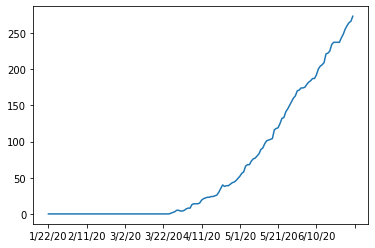

In [7]:
data.iloc[45, 3:].plot()

Create new dataframe with delta cases per date. Join with county population table.

In [8]:
data_deltas = pd.DataFrame(data[['Admin2', 'Province_State', 'Combined_Key']])
for i in range(4,len(data.columns)):     #check index with df form
  data_deltas[data.columns[i]] = data[data.columns[i]] - data[data.columns[i-1]]

In [9]:
data_deltas.rename(columns={'Admin2':'County'}, inplace=True)

### Population Density

Source: US Census (https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND)

In [10]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/population_counties.csv', sep=';', decimal=',')

In [11]:
county_area = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/counties_area.csv', sep=";")


Source: USPS (https://pe.usps.com/text/pub28/28apb.htm). A dictionary mapping for 2-letter state names

In [12]:
state_2l = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/states_2l.csv', sep=';')
st_2l_d = dict(zip(state_2l.iloc[:,0], state_2l.iloc[:,1]))

Transform combined county names to format with 2-letter states

In [13]:
tmp = np.transpose([i.split(', ') for i in df_pop['County']])
df_pop['County'] = tmp[0]
df_pop['State'] = [st_2l_d[i] for i in tmp[1]]

In [14]:
df_pop['County'] = df_pop['County'] + ', ' + df_pop['State']

Join tables with population and area data to calculate population density

In [15]:
county_area.rename(columns={'Areaname':'County'}, inplace=True)

In [16]:
df_pop = df_pop.join(county_area.set_index('County'), on='County', how='left')

In [17]:
df_pop['Population Density'] = df_pop['Population']/df_pop['LND110210D']
df_pop = df_pop[df_pop['Population Density'].isnull() == False]
del df_pop ['Population']
del df_pop['LND110210D']
del df_pop['STCOU']
del df_pop['State']

Transform data_deltas to the same key format as in population density table

In [18]:
data_deltas = data_deltas[data_deltas['Province_State'].isin(st_2l_d.keys())]
data_deltas['State'] = [st_2l_d[i] for i in data_deltas['Province_State']]
del data_deltas['Province_State']
data_deltas['County'] = data_deltas['County'] + ', ' + data_deltas['State']
del data_deltas['Combined_Key']
del data_deltas['State']

Join data_deltas table with population density one to create a time series of deltas divided by population density

In [19]:
data_dens = data_deltas.join(df_pop.set_index('County'), on='County', how='inner')

In [20]:
data_deltas_rel = pd.DataFrame(data_dens['County'])
for i in range(1, data_dens.shape[1] - 1):
    data_deltas_rel[data_dens.columns[i]] = data_dens[data_dens.columns[i]]/data_dens['Population Density']

Replace negative values with their absolutes, assuming there was a mistake in collecting/processing

In [21]:
data_deltas_rel.iloc[:,1:] = data_deltas_rel.iloc[:,1:].abs()

Create a list of time series for linear regressions:
1) trim zeros on the left
2) find the sequence of max length
3) pad all the other sequences with zeros from the left to the length of maximal (in order to build common model for several series)

In [31]:
lst = []
names = []
for i in range(data_deltas_rel.shape[0]):
    county_trimmed = list(np.trim_zeros(data_deltas_rel.iloc[i,1:], 'f'))
    if county_trimmed.count(0.0)/len(county_trimmed) <= 0.5:
        names.append(data_deltas_rel.iloc[i,0])
        lst.append(county_trimmed)
l = max([len(i) for i in lst])
for i in range(len(lst)):
    lst[i] = [names[i]] + list(np.pad(lst[i], (l - len(lst[i]), 0)))

### Linear Regressions

In [32]:
norm_lst = []
lr_lst = []
county_lst = []
x_lst = []
ypr_lst = []
y_lst = []
ts_size = len(lst[0]) - 1
x_range = np.array(range(ts_size))
x_range2 = np.array(range(ts_size))**2
x_range3 = np.array(range(ts_size))**3
x_range4 = np.array(range(ts_size))**4
x = [x_range, x_range2, x_range3, x_range4]
x = sm.add_constant(np.transpose(x))
for i in range(len(lst)):
    y = np.array(lst[i])[1:].astype('float32')
    y_mean = np.mean(y)
    jb_test = sm.stats.stattools.jarque_bera(y)   #check normality of data
    if jb_test[1] < 0.1:
        norm_lst.append(lst[i])
        x1 = x[:, :1]
        lr_fin = sm.OLS(y, x1).fit()
        for j in range(2, 5):
            lr0 = lr_fin
            x0 = x1
            y_pr0 = lr0.predict(x0)
            ssr0 = sum((y_pr0 - y_mean)**2)
            x1 = x[:, :j+1]
            lr1 = sm.OLS(y, x1).fit()
            y_pr1 = lr1.predict(x1)
            ssr1 = sum((y_pr1 - y_mean)**2)
            ssr_new = ssr1 - ssr0
            mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
            if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
                y_pr = y_pr0
                x_fin = x0
                break
            y_pr = y_pr1
            x_fin = x1
            lr_fin = lr1          #check residuals for normality and abscence of heteroskedasticity
        if sm.stats.stattools.jarque_bera(lr_fin.resid)[1] < 0.1 and het_breuschpagan(lr_fin.resid, x[:, :len(lr_fin.params)])[-1] < 0.1:
            county_lst.append(lst[i][0])       #save model if it passes the tests
            lr_lst.append(lr_fin)
            ypr_lst.append(y_pr)
            y_lst.append(y)

In [33]:
p = max([len(reg.params) for reg in lr_lst]) - 1

Normalizing all the values which are going to be used in clustering, so clustering is performed based only on shape

In [34]:
nz = preprocessing.Normalizer('max')
ypr_norm = nz.fit_transform(ypr_lst)

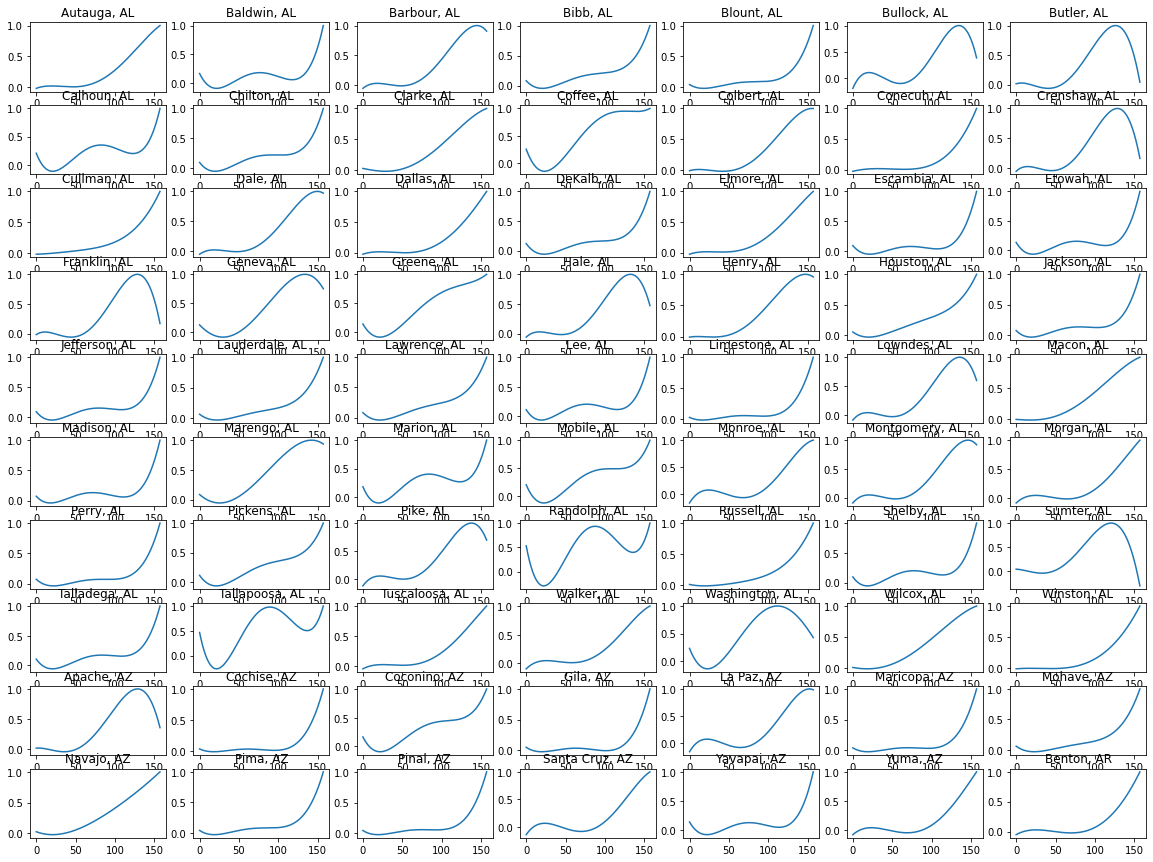

In [28]:
fig, axs = plt.subplots(10, 7, figsize=(20,15))
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(ypr_norm[i])
    axs[i//7, np.mod(i,7)].set_title(county_lst[i])

### Smoothing

Using Holt's linear smoothing as the data contans treand, but no seasonality; parameters are discussable as the optimizing procedure failed to converge

In [35]:
smooth_lst = []
county_tmp = [all]
for i in range(len(lst)):
    holt = Holt(lst[i][1:])
    fit = holt.fit(smoothing_level=.06, smoothing_slope=.06)
    smooth_lst.append(fit.fittedvalues)
    county_tmp.append(lst[i][0])

In [36]:
nz = preprocessing.Normalizer('max')
smooth_norm = nz.fit_transform(smooth_lst)

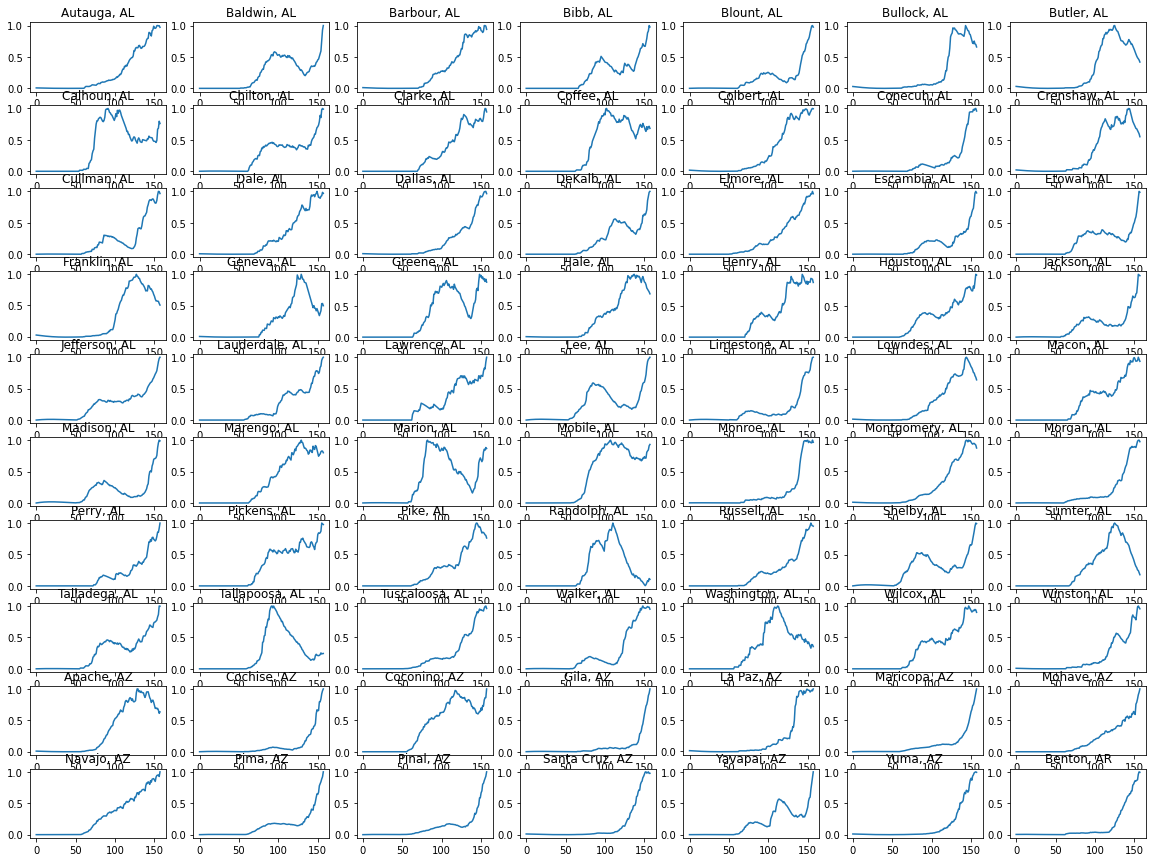

In [31]:
fig, axs = plt.subplots(10, 7, figsize=(20,15))
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(smooth_norm[i])
    axs[i//7, np.mod(i,7)].set_title(county_lst[i])

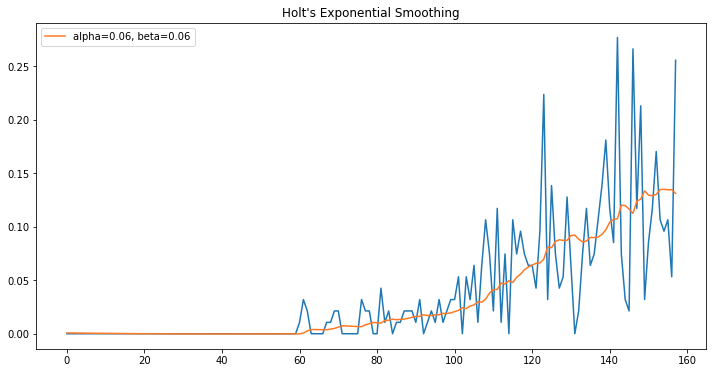

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_lst[0])
ax.plot(smooth_lst[0], label="alpha="+str(fit.params['smoothing_level'])[:4]+", beta="+str(fit.params['smoothing_slope'])[:4], color='#ff7823')
plt.title("Holt's Exponential Smoothing")
plt.legend();

Building regressions based on smoothed data

In [38]:
norm_lst_s = []
lr_lst_s = []
county_lst_s = []
ypr_lst_s = []
y_lst_s = []
ts_size = len(smooth_lst[0])
x_range = np.array(range(ts_size))
x_range2 = np.array(range(ts_size))**2
x_range3 = np.array(range(ts_size))**3
x_range4 = np.array(range(ts_size))**4
xs = [x_range, x_range2, x_range3, x_range4]
xs = sm.add_constant(np.transpose(xs))
for i in range(len(smooth_lst)):
    y = np.array(smooth_lst[i]).astype('float32')
    y_mean = np.mean(y)
    jb_test = sm.stats.stattools.jarque_bera(y)   #check normality of data
    if jb_test[1] < 0.1:
        norm_lst_s.append(smooth_lst[i])
        x1 = xs[:, :1]
        lr_fin = sm.OLS(y, x1).fit()
        for j in range(2, 5):
            lr0 = lr_fin
            x0 = x1
            y_pr0 = lr0.predict(x0)
            ssr0 = sum((y_pr0 - y_mean)**2)
            x1 = xs[:, :j+1]
            lr1 = sm.OLS(y, x1).fit()
            y_pr1 = lr1.predict(x1)
            ssr1 = sum((y_pr1 - y_mean)**2)
            ssr_new = ssr1 - ssr0
            mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
            if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
                y_pr = y_pr0
                x_fin = x0
                break
            y_pr = y_pr1
            x_fin = x1
            lr_fin = lr1          #check residuals for normality and abscence of heteroskedasticity
        if sm.stats.stattools.jarque_bera(lr_fin.resid)[1] < 0.1 and het_breuschpagan(lr_fin.resid, xs[:, :len(lr_fin.params)])[-1] < 0.1:
            county_lst_s.append(county_tmp[i])       #save model if it passes the tests
            lr_lst_s.append(lr_fin)
            ypr_lst_s.append(y_pr)
            y_lst_s.append(y)

In [39]:
nz = preprocessing.Normalizer('max')
ypr_norm_s = nz.fit_transform(ypr_lst_s)

Getting the interssection of both metods to make the future performance comparison possible

In [40]:
counties = list(set(county_lst) & set(county_lst_s)) 

In [41]:
inter_idx1 = [county_lst.index(x) for x in counties]
inter_idx2 = [county_lst_s.index(x) for x in counties]M

An example picture of a time series and 2 fitted curves

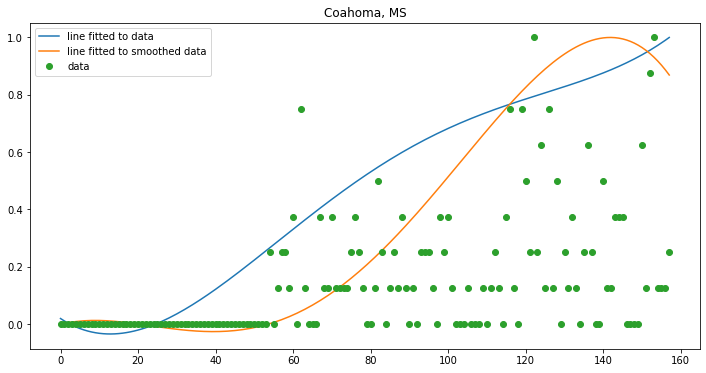

In [46]:
nz = preprocessing.Normalizer('max')
y_norm = nz.fit_transform(y_lst)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ypr_norm[inter_idx1[1]], label='line fitted to data')
ax.plot(ypr_norm_s[inter_idx2[1]], label='line fitted to smoothed data')
ax.plot(y_norm[inter_idx1[1]], 'o', label='data')
plt.title(counties[1])
plt.legend();

### Regression Mixtures

In [ ]:
x_range = np.array(range(1, 35))  #np.array([2,6,9,13,21,26,37,40,44,45])
x1 = np.array([x_range**0, x_range, x_range**2, x_range**3, x_range**4]).T

In [ ]:
x_range

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [ ]:
ypr_test = np.array(ypr_norm)[:,x_range*4]

In [45]:
k = 4

In [71]:
class Regression_Mixtures_Model:
    def __init__(self, k, n, p, ts_size):
        self.k = k
        self.n = n
        self.p = p
        self.tslen = ts_size
        self.ll_old = -np.inf
        self.ll_new = -100000000000000000000000000
        self.ll_stat = []
        self.clust_stat = []

    def indicator_max(self, array):
        max_idx = max(list(zip(array, range(self.k))))
        return [0]*(max_idx[1])+[1]+[0]*(self.k-max_idx[1]-1)
    
    def init_EM(self, ypr_lst, x):
        self.tau_lst = []
        for i in range(self.n):
            t = np.random.randint(1, 100, self.k)
            self.tau_lst.append(t/sum(t))
        self.tau_lst = np.array(self.tau_lst)
        self.x_new = np.tile(x.T, self.n).T
        self.y_new = np.concatenate(ypr_lst)
   
    def Expectation(self, ypr_lst, x):
        self.tau_lst = []
        self.ll_old = self.ll_new
        ll_lst = []
        #cov_m = [i*np.identity(self.tslen) for i in self.cov_lst]
        denom = np.sqrt(2*np.pi*self.cov_lst)
        for i in range(self.n):
            #err = abs([ypr_lst[i]]*self.k - np.dot(x, np.transpose(self.par_lst)).T)
            #prbs = self.pi*np.array([float(Decimal(math.exp(-np.dot(np.dot(err[j].T, np.linalg.inv(cov_m[j])), err[j])/2))/Decimal(np.sqrt((2*np.pi)**self.tslen*self.cov_lst[j]**self.tslen))) for j in range(self.k)])
            #num = np.exp(-sum((([ypr_lst[i]]*self.k - np.dot(x, np.transpose(self.par_lst)).T)**2).T)/(2*self.cov_lst))
            #prbs = self.pi*num/denom
            prbs = self.pi*[multivariate_normal(np.dot(x,self.par_lst[j]), self.cov_lst[j]).pdf(ypr_lst[i]) for j in range(self.k)]
            self.tau_lst.append(prbs/sum(prbs))
            ll_lst.append(np.log(prbs))
        ll_lst = np.array(ll_lst)
        self.tau_lst = np.array(self.tau_lst)
        self.ll_new = sum(sum(ll_lst*self.tau_lst))
        self.ll_stat.append(self.ll_new)
        self.clust_stat.append(sum(np.array([self.indicator_max(self.tau_lst[i]) for i in range(self.n)])))

    def Maximization(self, ypr_lst, x):
        self.pi = 1/self.n*sum(self.tau_lst)
        ttt = [np.ravel([np.tile(self.tau_lst[j][i], self.tslen) for j in range(self.n)]) for i in range(self.k)]
        off = 0
        Hk = [sps.dia_matrix((ttt[i], off), shape=(len(ttt[i]), len(ttt[i]))) for i in range(self.k)]
        pt1_new = [np.linalg.inv(np.dot(sps.csr_matrix.dot(self.x_new.T, Hk[i]), self.x_new)) for i in range(self.k)]
        self.par_lst = [np.dot(sps.csr_matrix.dot(np.dot(pt1_new[i], self.x_new.T), Hk[i]), self.y_new) for i in range(self.k)]
        self.cov_lst = [np.dot(sps.csr_matrix.dot((self.y_new - np.dot(self.x_new, self.par_lst[i])).T, Hk[i]), self.y_new - np.dot(self.x_new, self.par_lst[i])) for i in range(self.k)]/sum(self.tau_lst)
        self.avg_disp = np.mean(self.cov_lst)
        self.cov_lst = np.array(self.cov_lst)**0
    
    def EM(self, ypr_lst, x, eps=0.01):
        self.init_EM(ypr_lst, x)
        for i in range(500):#while self.ll_new - self.ll_old > eps:
            #break
            self.Maximization(ypr_lst, x)
            self.Expectation(ypr_lst, x)
            #break
        self.output = [self.indicator_max(self.tau_lst[i]) for i in range(self.n)]


In [72]:
rm1 = Regression_Mixtures_Model(k, len(counties), p, len(x))
rm1.EM(np.array(ypr_norm)[inter_idx1], x, eps=0.01)

In [73]:
rm2 = Regression_Mixtures_Model(k, len(counties), p, len(xs))
rm2.EM(np.array(ypr_norm_s)[inter_idx2], xs, eps=0.01)

In [74]:
print(rm1.ll_stat[-1])
print(rm2.ll_stat[-1])

-97208.40260156401
-97347.15454664604


In [75]:
print(rm1.clust_stat[-1])
print(rm2.clust_stat[-1])

[109 105 147 297]
[208 141 130 179]


In [76]:
t = sum((np.array(rm1.output)*np.array([[1,2,3,4]]*rm1.n)).T)
idxs1 = [j for j, e in enumerate(t) if e == 1]
idxs2 = [j for j, e in enumerate(t) if e == 2]
idxs3 = [j for j, e in enumerate(t) if e == 3]
idxs4 = [j for j, e in enumerate(t) if e == 4]
idxs = [idxs1, idxs2, idxs3, idxs4]

In [77]:
t1 = sum((np.array(rm2.output)*np.array([[1,2,3,4]]*rm2.n)).T)
idxs1s = [j for j, e in enumerate(t1) if e == 1]
idxs2s = [j for j, e in enumerate(t1) if e == 2]
idxs3s = [j for j, e in enumerate(t1) if e == 3]
idxs4s = [j for j, e in enumerate(t1) if e == 4]
idxss = [idxs1s, idxs2s, idxs3s, idxs4s]

In [78]:
[[len(set(x)&set(y)) for y in idxss] for x in idxs]

[[13, 58, 9, 29], [33, 14, 30, 28], [24, 31, 34, 58], [138, 38, 57, 64]]

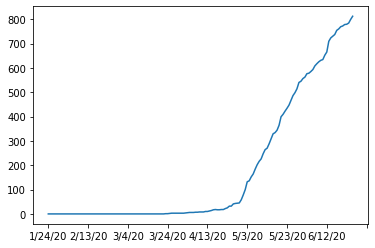

In [ ]:
data.iloc[29,5:].plot()

In [ ]:
data_deltas_rel.iloc[29,0]

'Franklin, AL'

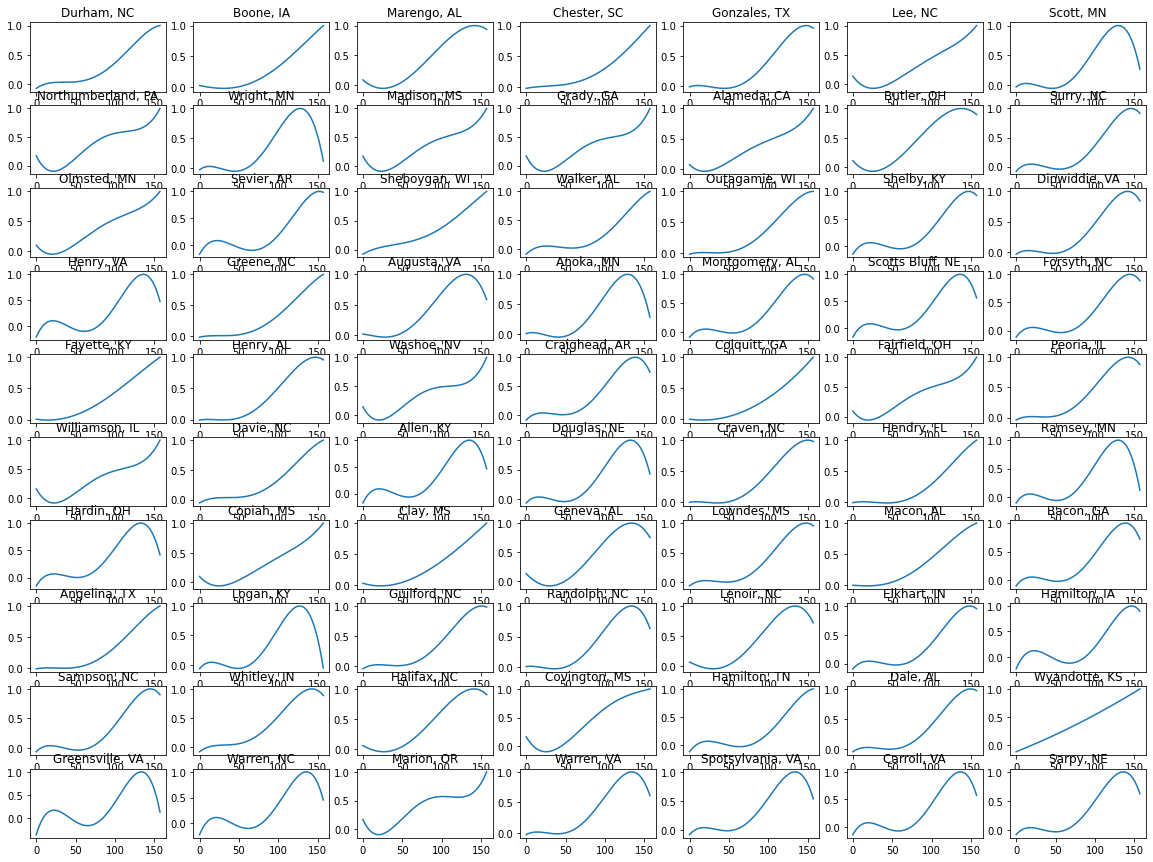

In [81]:
fig, axs = plt.subplots(10,7, figsize=(20,15))
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(np.array(ypr_norm)[np.array(inter_idx1)[idxs2]][i])
    axs[i//7, np.mod(i,7)].set_title(np.array(county_lst)[np.array(inter_idx1)[idxs2]][i])

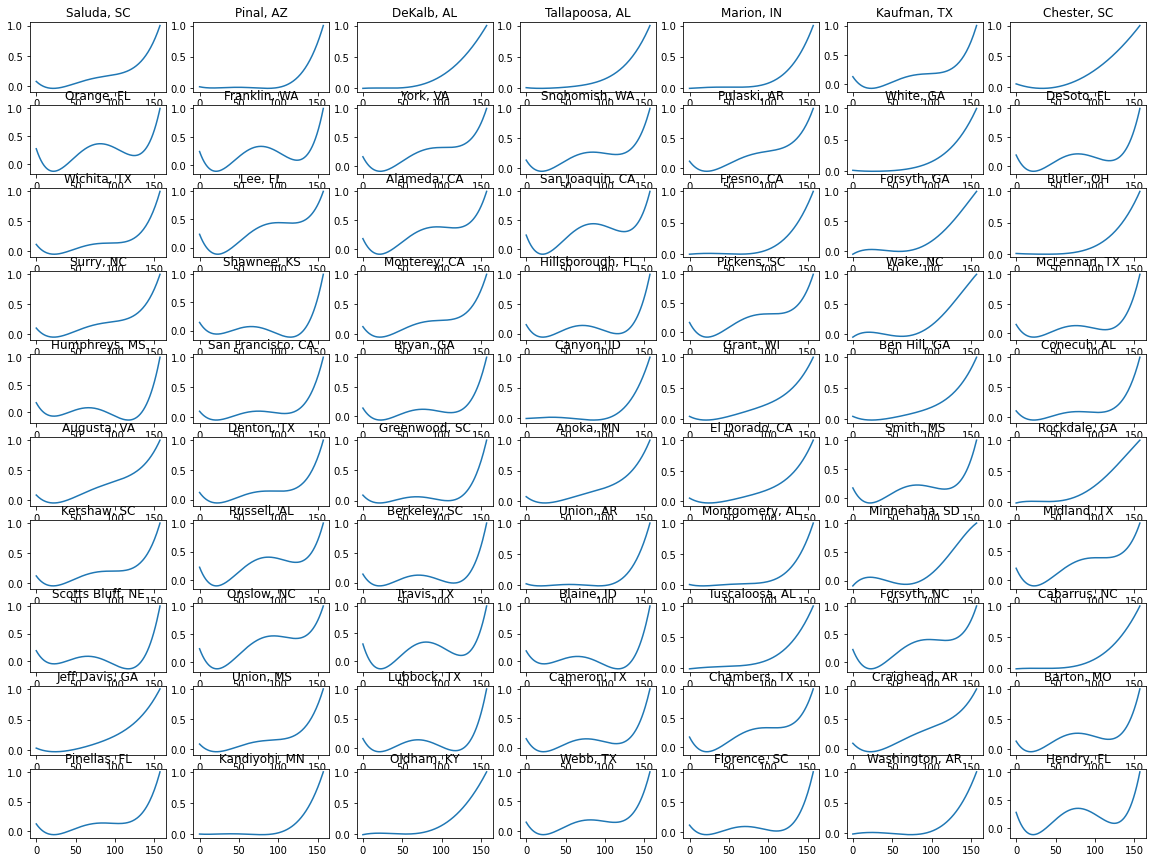

In [80]:
fig, axs = plt.subplots(10,7, figsize=(20,15))
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(np.array(ypr_norm_s)[np.array(inter_idx2)[idxs1s]][i])
    axs[i//7, np.mod(i,7)].set_title(np.array(county_lst_s)[np.array(inter_idx2)[idxs1s]][i])

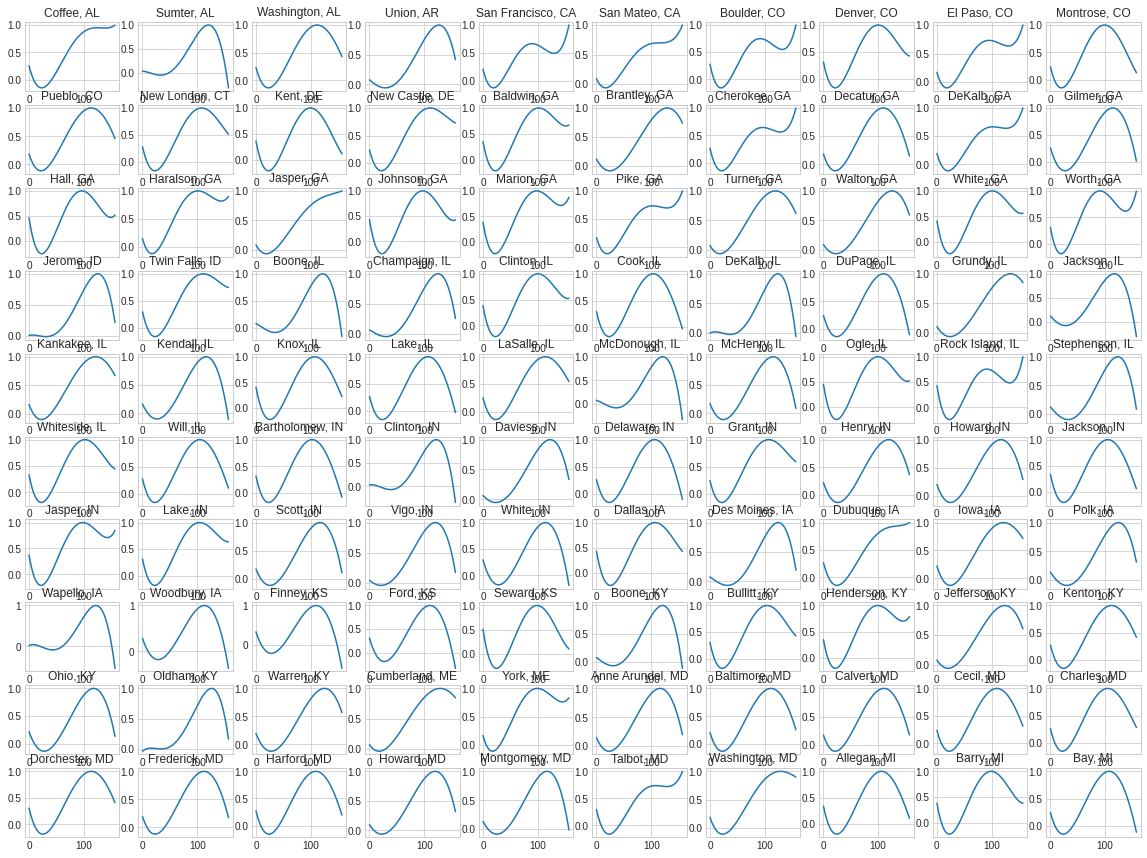

In [52]:
fig, axs = plt.subplots(10,10, figsize=(20,15))
for i in range(100):
    axs[i//10, np.mod(i,10)].plot(np.array(ypr_norm)[idxs2][i])
    axs[i//10, np.mod(i,10)].set_title(np.array(county_lst)[idxs2][i])

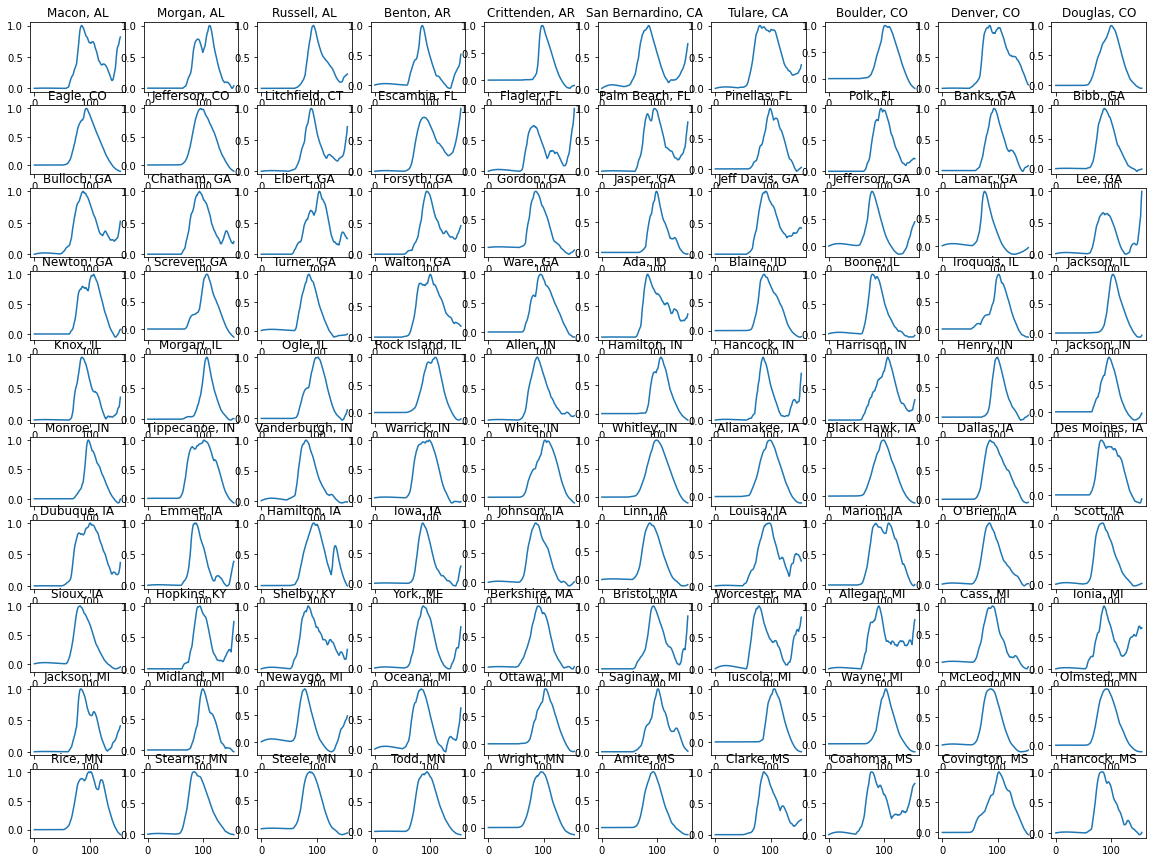

In [ ]:
fig, axs = plt.subplots(10,10, figsize=(20,15))
for i in range(100):
    axs[i//10, np.mod(i,10)].plot(np.array(smooth_norm)[idxs3][i])
    axs[i//10, np.mod(i,10)].set_title(np.array(county_lst)[idxs3][i])

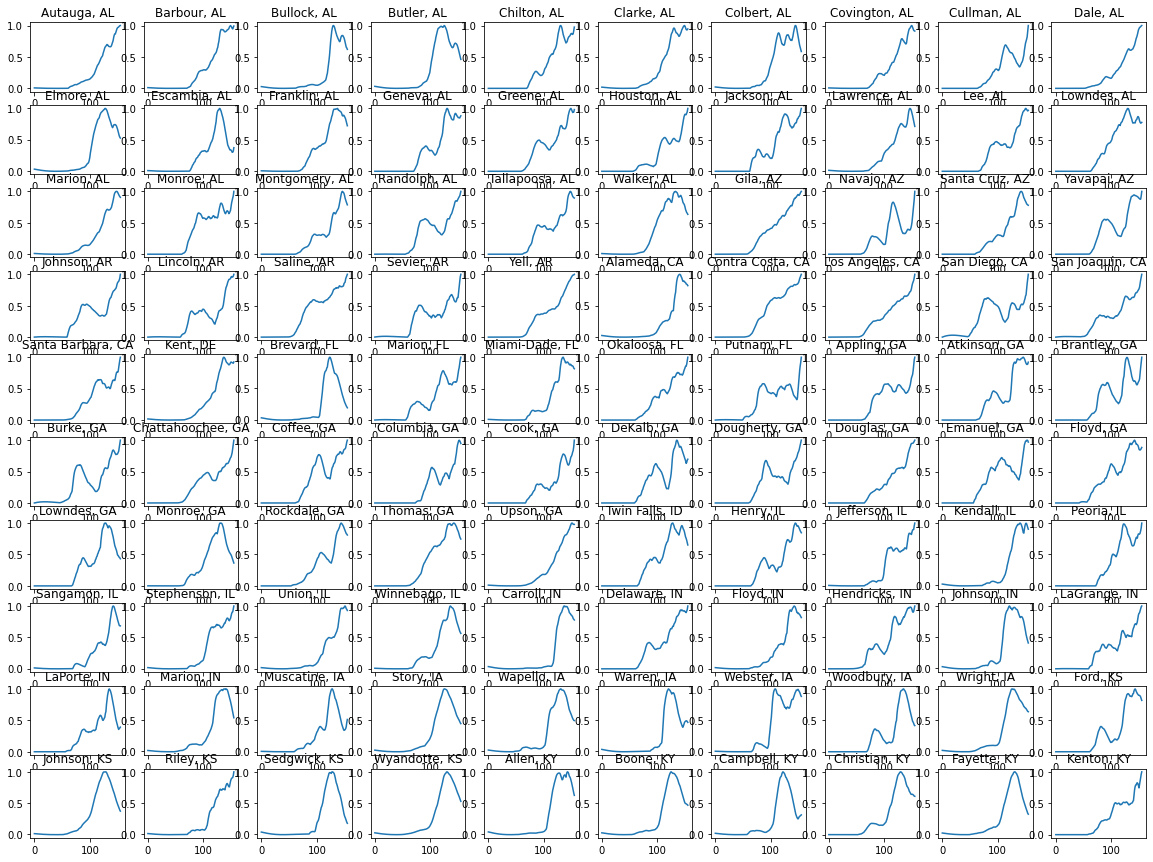

In [ ]:
fig, axs = plt.subplots(10,10, figsize=(20,15))
for i in range(100):
    axs[i//10, np.mod(i,10)].plot(np.array(smooth_norm)[idxs4][i])
    axs[i//10, np.mod(i,10)].set_title(np.array(county_lst)[idxs4][i])

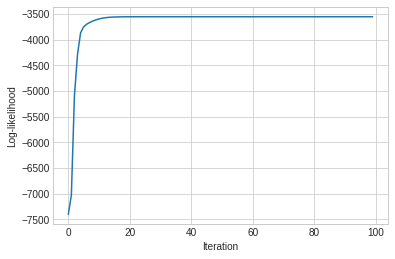

In [51]:
plt.plot(rm.ll_stat)
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')
plt.show()

### Number of clusters

In [ ]:
elbow_stat1 = []
elbow_stat2 = []
time_stat = []
for i in range(2, 10):
    s = time()
    rm = Regression_Mixtures_Model(i, len(ypr_norm), p, len(x))
    rm.EM(ypr_norm, x, eps=0.01)
    e = time()
    time_stat.append(e - s)
    elbow_stat1.append(rm.ll_new)
    elbow_stat2.append(rm.avg_disp)

In [ ]:
disps = [[4.754924526839557,
 3.2469438822049335,
 2.6883450402588487,
 2.474946020248533,
 2.194012752890731,
 2.094382776136229,
 2.0940587532401462,
 2.065396169887487], [4.760495894717097,
 3.246931261189052,
 2.689366922965439,
 2.395684852768329,
 2.2495746434214654,
 2.165543842513171,
 2.0955615732861634,
 2.09455378792666]]

In [ ]:
lls = [[-138039.99474726233,
 -137608.11381803016,
 -137589.39510128746,
 -137669.6857016463,
 -137686.11650060516,
 -137714.13994637947,
 -137817.54234286174,
 -138000.46537469962], [-138040.0522498223,
 -137608.11598720195,
 -137589.36380371792,
 -137635.148047047,
 -137661.52328017558,
 -137875.42014876695,
 -137823.42015555996,
 -137870.12794952988]]

In [ ]:
sum(np.array(lls))/2

array([-138040.02349854, -137608.11490262, -137589.3794525 ,
       -137652.41687435, -137673.81989039, -137794.78004757,
       -137820.48124921, -137935.29666211])

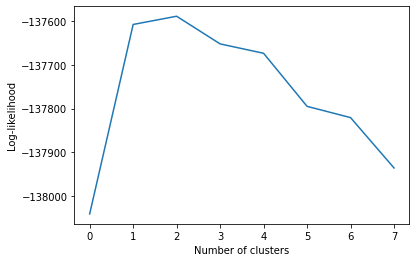

In [ ]:
plt.plot(sum(np.array(lls))/2)
plt.ylabel('Log-likelihood')
plt.xlabel('Number of clusters')
plt.show()

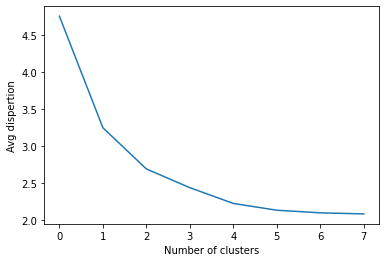

In [ ]:
plt.plot(sum(np.array(disps))/2)
plt.ylabel('Avg dispertion')
plt.xlabel('Number of clusters')
plt.show()

In [ ]:
with open('f1.txt','w') as f:
    f.write('\n'.join(idxs1))
with open('f2.txt','w') as f:
    f.write('\n'.join(idxs2))
with open('f3.txt','w') as f:
    f.write('\n'.join(idxs3))

[]